In [1]:
'''!pip install aicrowd-cli
API_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" 
!aicrowd login --api-key $API_KEY
!aicrowd dataset download --challenge global-wheat-challenge-2021'''

'!pip install aicrowd-cli\nAPI_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" \n!aicrowd login --api-key $API_KEY\n!aicrowd dataset download --challenge global-wheat-challenge-2021'

In [2]:
'''import shutil
shutil.copyfile('/content/train.zip',
                '/content/drive/MyDrive/aicrowd_wheat/train.zip')
shutil.copyfile('/content/test.zip',
                '/content/drive/MyDrive/aicrowd_wheat/test.zip')
shutil.copyfile('/content/submission.csv',
                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')'''

"import shutil\nshutil.copyfile('/content/train.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/train.zip')\nshutil.copyfile('/content/test.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/test.zip')\nshutil.copyfile('/content/submission.csv',\n                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')"

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 19 08:52:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q albumentations==0.4.6

In [6]:
import shutil
import pandas as pd
import numpy as np 
import os
import cv2
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN  
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import StratifiedKFold, train_test_split
import joblib

In [7]:
from torchvision.models.detection._utils import Matcher
from torchvision.ops.boxes import box_iou

def accuracy(src_boxes, pred_boxes,  iou_threshold = 1.):
  """
  The accuracy method is not the one used in the evaluator but very similar
  """
  total_gt = len(src_boxes)
  total_pred = len(pred_boxes)
  if total_gt > 0 and total_pred > 0:


    # Define the matcher and distance matrix based on iou
    matcher = Matcher(iou_threshold,iou_threshold,allow_low_quality_matches=False) 
    match_quality_matrix = box_iou(src_boxes,pred_boxes)

    results = matcher(match_quality_matrix)
    
    true_positive = torch.count_nonzero(results.unique() != -1)
    matched_elements = results[results > -1]
    
    #in Matcher, a pred element can be matched only twice 
    false_positive = torch.count_nonzero(results == -1) + ( len(matched_elements) - len(matched_elements.unique()))
    false_negative = total_gt - true_positive

        
    return  true_positive / ( true_positive + false_positive + false_negative )

  elif total_gt == 0:
      if total_pred > 0:
          return torch.tensor(0.).cuda()
      else:
          return torch.tensor(1.).cuda()
  elif total_gt > 0 and total_pred == 0:
      return torch.tensor(0.).cuda()

In [8]:
if(os.path.isdir('train')):
  print('folder exists, skip unzip procedure')
else:
  shutil.copyfile('/content/drive/MyDrive/aicrowd_wheat/train.zip','/content/train.zip')
  shutil.unpack_archive('./train.zip')
  #!unzip train.zip

folder exists, skip unzip procedure


In [9]:
len(os.listdir('./train/')), os.listdir('./train/')[0:3]

(3655,
 ['d1b8afab1a04fbdcdcf82699c1367e0e639a3e6e4be7fac97a40dd096ce4799f.png',
  'ff3e4e3b063c36b73effb6e69805ab88b5981d50ce8258dadcca8c6176084b8b.png',
  '1cefe30eddb53d171e2853f764a3a6838aad0b9023f5a202b05102051435f2e0.png'])

In [10]:
df_train = pd.read_csv('./train.csv')
df_train['image_id'] = df_train['image_name']
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   3657 non-null   object
 1   BoxesString  3657 non-null   object
 2   domain       3657 non-null   int64 
 3   image_id     3657 non-null   object
dtypes: int64(1), object(3)
memory usage: 114.4+ KB


In [11]:
df_train[df_train.BoxesString=='no_box'].shape[0], \
df_train[df_train.BoxesString=='no_box'].shape[0]*100/df_train.shape[0]

(50, 1.3672409078479628)

### Filter images with multiple domains

In [12]:
tf = df_train[['image_id','domain']].groupby(['image_id']).count().reset_index()
domain_lkup = df_train[~df_train.image_id.isin(tf[tf.domain>1].image_id.values)][['image_id','domain']]
tf[tf.domain>1].image_id.values

array(['73d4c61b8be64a946df940e3e5cdceecb662960363c84a29fb8e99d4b660fa0e',
       '8ec1474b9cdc0fd870b443439daa56660c57140c051a8a49052d22d828728f12'],
      dtype=object)

In [13]:
df_train_final = pd.concat([pd.Series(row['image_id'], row['BoxesString'].split(';')) \
                            for _, row in df_train[df_train.BoxesString!='no_box'].iterrows()]).reset_index()
df_train_final.columns = ['box','image_id']
df_train_final['x_min'] = df_train_final.box.apply(lambda x:x.split(' ')[0]).apply(int)
df_train_final['y_min'] = df_train_final.box.apply(lambda x:x.split(' ')[1]).apply(int)
df_train_final['x_max'] = df_train_final.box.apply(lambda x:x.split(' ')[2]).apply(int)
df_train_final['y_max'] = df_train_final.box.apply(lambda x:x.split(' ')[3]).apply(int)
df_train_final['x'] = df_train_final['x_min']
df_train_final['y'] = df_train_final['y_min']
df_train_final['w'] = df_train_final['x_max'] - df_train_final['x_min']
df_train_final['h'] = df_train_final['y_max'] - df_train_final['y_min']
df_train_final = df_train_final.merge(domain_lkup, on=['image_id'], how='left')
df_train_final.fillna(-1, inplace=True)
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163690 entries, 0 to 163689
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   box       163690 non-null  object 
 1   image_id  163690 non-null  object 
 2   x_min     163690 non-null  int64  
 3   y_min     163690 non-null  int64  
 4   x_max     163690 non-null  int64  
 5   y_max     163690 non-null  int64  
 6   x         163690 non-null  int64  
 7   y         163690 non-null  int64  
 8   w         163690 non-null  int64  
 9   h         163690 non-null  int64  
 10  domain    163690 non-null  float64
dtypes: float64(1), int64(8), object(2)
memory usage: 15.0+ MB


In [14]:
df_train_final.head()
# df_train.domain.value_counts()

,box,image_id,x_min,y_min,x_max,y_max,x,y,w,h,domain
0,949 967 999 994,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,949,967,999,994,949,967,50,27,0.0
1,368 649 443 685,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,368,649,443,685,368,649,75,36,0.0
2,118 280 185 333,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,118,280,185,333,118,280,67,53,0.0
3,899 564 947 609,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,899,564,947,609,899,564,48,45,0.0
4,604 243 682 297,7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...,604,243,682,297,604,243,78,54,0.0


In [15]:
DIR_INPUT = './'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [16]:
'''train_set, test_set = train_test_split(df_train.image_id.values, test_size=0.2, random_state=42)
train_set.shape, test_set.shape
joblib.dump(train_set, '/content/drive/MyDrive/aicrowd_wheat/train_set')
joblib.dump(test_set, '/content/drive/MyDrive/aicrowd_wheat/test_set')
kfold = StratifiedKFold(n_splits=5)
folds = []
for train_ids, test_ids in kfold.split(df_train.image_id.values, df_train.domain.values):
  folds.append([df_train.image_id.values[train_ids], df_train.image_id.values[test_ids]])
joblib.dump(folds, '/content/drive/MyDrive/aicrowd_wheat/kfolds')'''

"train_set, test_set = train_test_split(df_train.image_id.values, test_size=0.2, random_state=42)\ntrain_set.shape, test_set.shape\njoblib.dump(train_set, '/content/drive/MyDrive/aicrowd_wheat/train_set')\njoblib.dump(test_set, '/content/drive/MyDrive/aicrowd_wheat/test_set')\nkfold = StratifiedKFold(n_splits=5)\nfolds = []\nfor train_ids, test_ids in kfold.split(df_train.image_id.values, df_train.domain.values):\n  folds.append([df_train.image_id.values[train_ids], df_train.image_id.values[test_ids]])\njoblib.dump(folds, '/content/drive/MyDrive/aicrowd_wheat/kfolds')"

In [17]:
train_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/train_set')
test_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/test_set')
kfold_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/kfolds')
train_images.shape, test_images.shape, len(kfold_images)

((2925,), (732,), 5)

In [18]:
valid_df = df_train_final[df_train_final['image_id'].isin(test_images)]
train_df = df_train_final[df_train_final['image_id'].isin(train_images)]
valid_df.shape, train_df.shape

((32281, 11), (131476, 11))

In [19]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [20]:
import random

In [21]:
'''def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
'''
def get_train_transform():
    return A.Compose([
                      A.ToGray(p=0.5),
                      A.Flip(p=0.5),
                      A.RandomBrightnessContrast(p=0.5),
                      A.Cutout(num_holes= random.randint(10, 20), max_h_size= 64, max_w_size =64, p = 0.40),
                      ToTensorV2(p=1.0)
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

## Train Model

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [23]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [24]:
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


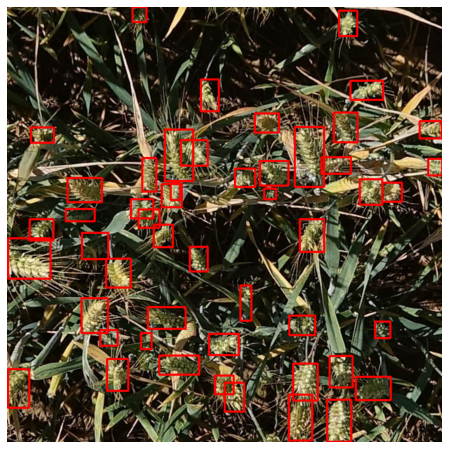

In [26]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [27]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
lr_rate=0.005
optimizer = torch.optim.SGD(params, lr=lr_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None

num_epochs = 40

In [29]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
filename = 'fasterrcnn_resnet50_epochs_'+str(num_epochs)+'_lr_'+str(lr_rate)+'_time_'+datetime.now().strftime(format='%d_%m_%Y_%H_%M')+'.pth'
torch.save(model.state_dict(), '/content/drive/MyDrive/aicrowd_wheat/'+filename)

## Evaluation

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
    drop_last=False
)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/aicrowd_wheat/'\
                                 +filename))
model.eval()
x = model.to(device)

In [ ]:
device

In [ ]:
results = []

for images, targets, image_ids in valid_data_loader:
  images = list(img.to(device) for img in images)
  outputs = model(images)
  # outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
  results.append([image_ids[0], targets[0], 
                  outputs[0]['boxes'].cpu().detach().numpy(), outputs[0]['scores'].cpu().detach().numpy()])

len(results)

In [ ]:
threshold = 0.55
performance = []
for row in results:
  image_id = row[0]
  actuals = row[1]['boxes']#.cpu().numpy().astype(np.int32)
  scores = row[3]
  predictions = row[2][scores>=threshold]
  acc = accuracy(torch.from_numpy(predictions), actuals, iou_threshold = .5)
  acc = np.float(acc.detach().cpu().numpy())
  performance.append([image_id, acc])
  
print(len(performance))
df_performance = pd.DataFrame(performance, columns=['image_id','acc'])
df_performance.acc.mean()

In [ ]:
for threshold in np.arange(0,1,0.05):
  performance = []
  for row in results:
    image_id = row[0]
    actuals = row[1]['boxes']#.cpu().numpy().astype(np.int32)
    scores = row[3]
    predictions = row[2][scores>=threshold]
    acc = accuracy(torch.from_numpy(predictions), actuals, iou_threshold = .5)
    acc = np.float(acc.detach().cpu().numpy())
    performance.append([image_id, acc])
    df_performance = pd.DataFrame(performance, columns=['image_id','acc'])
    acc = df_performance.acc.mean()
  print('threshold:',round(threshold,2),', acc:',round(acc,4))

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
boxes = outputs[0]['boxes'].detach().numpy()
scores = outputs[0]['scores'].detach().numpy()
boxes = boxes[scores>=0.5]
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
while True:
  pass